In [2]:
%cd ..

/Users/juansegundohevia/Documents/repos/ConceptGuidedColorization


In [ ]:
from palette_model import ColorizationModel as model
from skimage.color import rgb2lab, lab2rgb
import os 
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import torch
from data_loader import ColorizationDataset
import util
from skimage import color
import numpy as np

In [5]:
CKP_PATH = "weights/ColorizationModel/"

In [164]:
G = model.UNet(imsize=256, add_L=True)
D = model.Discriminator(add_L=True , imsize=256)

# load weights
G.load_state_dict(torch.load(os.path.join(CKP_PATH, "44_G.ckpt"), map_location=torch.device('cpu')))
D.load_state_dict(torch.load(os.path.join(CKP_PATH, "44_D.ckpt"), map_location=torch.device('cpu')))

<All keys matched successfully>

In [165]:
G.eval()
D.eval()

Discriminator(
  (main): Sequential(
    (0): Conv2d(18, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.01, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (3): LeakyReLU(negative_slope=0.01, inplace=True)
    (4): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (5): LeakyReLU(negative_slope=0.01, inplace=True)
    (6): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (7): LeakyReLU(negative_slope=0.01, inplace=True)
    (8): Conv2d(512, 1024, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (9): LeakyReLU(negative_slope=0.01, inplace=True)
  )
  (conv1): Conv2d(1024, 1024, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (fc): Sequential(
    (0): BatchNorm1d(65536, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1): Linear(in_features=65536, out_features=1, bias=True)
    (2): Sigmoid()
  )
)

In [425]:
def visualize_palette(sample_palette):

    fig, ax = plt.subplots(1, 5, figsize=(15, 3))

    for idx, col in enumerate(lab2rgb(sample_palette.reshape(5, 3))):
        ax[idx].imshow(np.ones((10, 10, 3)) * col)
        ax[idx].axis('off')

        

In [363]:
# testset = ColorizationDataset("data/bird256/test_palette/images", "data/bird256/test_palette/palettes", batch_size=1,num_workers=4)
testset = ColorizationDataset("data/bird256/train_palette/images", "data/bird256/train_palette/palettes", batch_size=1,num_workers=4)

# From official repo code

In [440]:
_img, _pal = testset[100]
images = _img.unsqueeze(0)

inputs, labels = util.process_image(images, batch_size=1, imsize=256)

_pal = _pal.view(-1, 5, 3).cpu().data.numpy()
for_global = util.process_palette_lab(_pal, batch_size=1)
side_inputs = util.process_global_sampling_lab(for_global, batch_size=1, imsize=256, hist_mean=0, hist_std=1)

Text(0.5, 1.0, 'Ground Truth Image (to be grayscaled)')

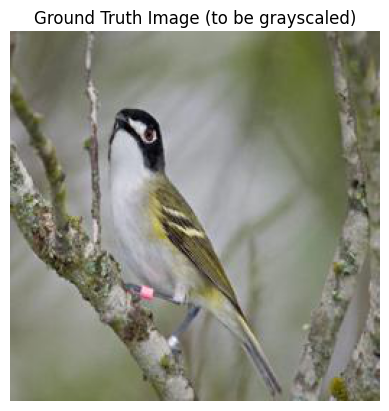

In [441]:
plt.imshow(_img.permute(1,2,0).numpy())
plt.axis('off')
plt.title("Ground Truth Image (to be grayscaled)")

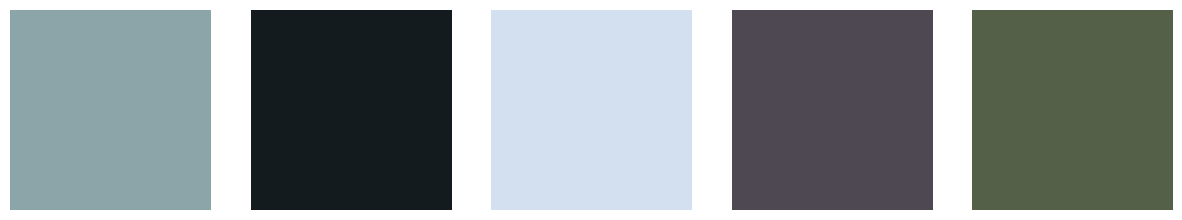

In [442]:
visualize_palette(_pal)

(np.float64(-0.5), np.float64(255.5), np.float64(255.5), np.float64(-0.5))

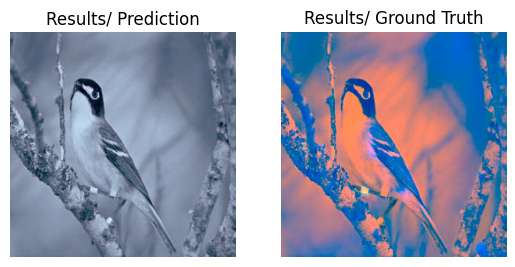

In [443]:
with torch.no_grad():
    res = G(inputs, side_inputs)

colored_img = torch.cat([inputs, res], 1).data.cpu().numpy().transpose((0, 2, 3, 1))
gt_img = images.cpu().numpy().transpose((0, 2, 3, 1))


k = 0
x = 0

colored_img[k][:, :, 0] = colored_img[k][:, :, 0] * 100
colored_img[k][:, :, 1] = (colored_img[k][:, :, 1] * 185) - 88
colored_img[k][:, :, 2] = (colored_img[k][:, :, 2] * 212) - 127
colored_img[k] = lab2rgb(colored_img[k].astype(np.float64), illuminant='D50')


gt_img[k][:, :, 0] = gt_img[k][:, :, 0] * 100
gt_img[k][:, :, 1] = (gt_img[k][:, :, 1] * 185) - 88
gt_img[k][:, :, 2] = (gt_img[k][:, :, 2] * 212) - 127
gt_img[k] = lab2rgb(gt_img[k].astype(np.float64), illuminant='D50')

fig2, axs2 = plt.subplots(ncols=2)
input_text = "Results"

axs2[0].set_title(input_text + '/ Prediction')
axs2[0].imshow(colored_img[x])
axs2[0].axis('off')

axs2[1].set_title(input_text + '/ Ground Truth')
axs2[1].imshow(_img.permute(1,2,0).numpy())

# axs2[1].imshow(gt_img[x])
axs2[1].axis('off')


In [430]:
print("L* range:", colored_img[:, :, 0].min(), colored_img[:, :, 0].max())
print("a* range:", colored_img[:, :, 1].min(), colored_img[:, :, 1].max())
print("b* range:", colored_img[:, :, 2].min(), colored_img[:, :, 2].max())

L* range: 0.0 1.0
a* range: 0.0 1.0
b* range: 0.0 1.0
